In [36]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
from multiprocessing import Pool
from glob import glob
from os.path import join
from pyproj import Proj
from sklearn.mixture import GaussianMixture
from hagelslag.evaluation.ContingencyTable import ContingencyTable
def load_storm_data_file(data_file, variable_names):
    try:
        run_filename = data_file.split("/")[-1][:-3].split("_")
        member = int(run_filename[6])
        run_date = run_filename[4]
        ds = xr.open_dataset(data_file)
        patch_arr = []
        all_vars = list(ds.variables.keys())
        meta_cols = ["center_lon", "center_lat", "valid_dates", "run_dates", "members"]
        return_dict = {"data_file": data_file, "meta": None, "data_patches": None}
        if np.all(np.in1d(variable_names, all_vars)):
            meta_dict = {}
            meta_dict["center_lon"] = ds["longitude"][:, 32, 32].values
            meta_dict["center_lat"] = ds["latitude"][:, 32, 32].values
            meta_dict["valid_dates"] = pd.DatetimeIndex(ds["valid_date"].values)
            meta_dict["run_dates"] = np.tile(run_date, meta_dict["valid_dates"].size)
            meta_dict["members"] = np.tile(member, meta_dict["valid_dates"].size)
            return_dict["meta"] = pd.DataFrame(meta_dict, columns=meta_cols)
            for variable in variable_names:
                patch_arr.append(ds[variable][:, 16:-16, 16:-16].values.astype(np.float32))
            return_dict["data_patches"] = np.stack(patch_arr, axis=-1)
            print(data_file, return_dict["meta"].size)
        ds.close()
        del patch_arr[:]
        del patch_arr
        del ds
        return return_dict
    except Exception as e:
        print(traceback.format_exc())
        raise e
        
def load_storm_patch_data(data_path, variable_names, n_procs):
    """


    Args:
        data_path:
        variable_names:
        n_procs:

    Returns:

    """
    data_patches = []
    data_meta = []

    data_files = sorted(glob(join(data_path, "*.nc")))
    pool = Pool(n_procs, maxtasksperchild=1)
    file_check = data_files[:]

    def combine_storm_data_files(return_obj):
        f_index = file_check.index(return_obj["data_file"])
        if return_obj["meta"] is not None:
            data_patches[f_index] = return_obj["data_patches"]
            data_meta[f_index] = return_obj["meta"]
        else:
            file_check.pop(f_index)
            data_patches.pop(f_index)
            data_meta.pop(f_index)

    for data_file in data_files:
        data_patches.append(None)
        data_meta.append(None)
        pool.apply_async(load_storm_data_file, (data_file, variable_names), callback=combine_storm_data_files)
    pool.close()
    pool.join()
    del pool
    all_data = np.vstack(data_patches)
    all_meta = pd.concat(data_meta, ignore_index=True)
    return all_data, all_meta

distances = np.arange(20000, 220000, 20000)

In [2]:
hail_data = load_storm_patch_data("/glade/work/dgagne/ncar_ens_storm_patches/", 
                      ["thompson_max_hail_k1_surface_current"], 4)

/glade/work/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_04.nc 650
/glade/work/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_03.nc 760
/glade/work/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_01.nc 640
/glade/work/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_02.nc 950
/glade/work/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_07.nc 760
/glade/work/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_06.nc 835
/glade/work/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_05.nc 605
/glade/work/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_08.nc 805
/glade/work/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_10.nc 700
/glade/work/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050400_mem_01.nc 460
/glade/work/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_09.nc 900
/glade/wor

In [3]:
hail_sizes = hail_data[0].ravel() * 1000
hail_sizes = hail_sizes[hail_sizes > 0]

In [4]:
max_hail = hail_data[0].max(axis=-1).max(axis=-1).max(axis=-1) * 1000

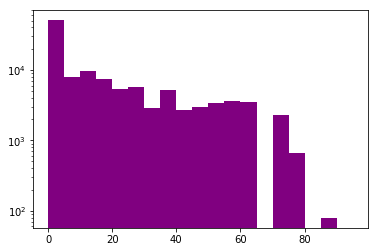

In [6]:
plt.hist(max_hail, bins=np.arange(0, 100, 5), color='purple', density=False)
plt.gca().set_yscale("log")

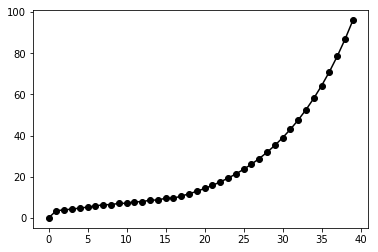

In [9]:
plt.plot(np.unique(max_hail), 'ko-')

In [12]:
hail_bins = np.unique(max_hail)[1:]
hail_bin_diffs = hail_bins[1:] - hail_bins[:-1]
hail_counts, _ = np.histogram(max_hail, hail_bins)
all_hail_samples = []
for h, hail_count in enumerate(hail_counts):
    all_hail_samples.append(np.random.uniform(hail_bins[h], hail_bins[h+1], size=hail_count))
hail_samples = np.concatenate(all_hail_samples)

(array([10802.,  9770.,  7459.,  6389.,  5100.,  3991.,  3638.,  3544.,
         3660.,  3389.,  2937.,  1879.,   626.,   237.,    55.]),
 array([ 6, 12, 18, 24, 30, 36, 42, 48, 54, 60, 66, 72, 78, 84, 90, 96]),
 <a list of 15 Patch objects>)

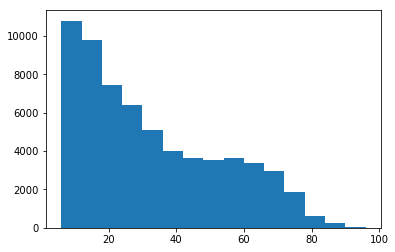

In [19]:
plt.hist(hail_samples, bins=np.arange(6, 102, 6))
#plt.gca().set_yscale('log')

(array([0.00832816, 0.30509493, 0.55532365, 0.70495479, 0.7845311 ,
        0.84807742, 0.87291112, 0.91436873, 0.93365833, 0.95258642,
        0.97046445, 0.98599488, 0.99573925, 0.99573925, 0.99936527,
        0.99995543, 0.99995543, 1.        , 1.        ]),
 array([ 0,  5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80,
        85, 90, 95]),
 <a list of 19 Patch objects>)

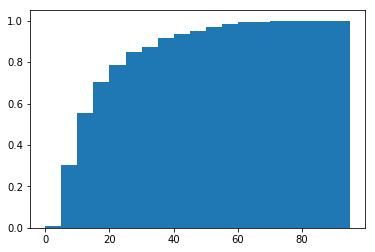

In [25]:
plt.hist(hail_sizes, bins=np.arange(0, 100, 5), density=True, cumulative=True)

In [39]:
hail_reports = pd.read_csv("../2016_hail.csv")

In [41]:
np.unique(hail_reports["mag"])

array([0.25, 0.5 , 0.7 , 0.75, 0.88, 1.  , 1.1 , 1.12, 1.25, 1.4 , 1.5 ,
       1.65, 1.75, 2.  , 2.1 , 2.17, 2.2 , 2.25, 2.3 , 2.5 , 2.75, 3.  ,
       3.11, 3.2 , 3.25, 3.43, 3.5 , 4.  , 4.25, 4.5 , 5.  , 5.25])

In [45]:
hail_bins_r = np.unique(hail_reports["mag"])
hail_counts_r, _ = np.histogram(hail_reports["mag"], hail_bins_r)
all_hail_samples_r = []
for h, hail_count in enumerate(hail_counts_r):
    all_hail_samples_r.append(np.random.uniform(hail_bins_r[h], hail_bins_r[h+1], size=hail_count))
hail_samples_r = np.concatenate(all_hail_samples_r)

(array([4.000e+00, 5.000e+00, 2.950e+02, 1.670e+03, 3.990e+03, 5.810e+02,
        4.520e+02, 4.380e+02, 1.006e+03, 4.990e+02, 2.100e+01, 4.400e+01,
        1.510e+02, 1.150e+02, 9.000e+01, 3.000e+00, 4.000e+00, 3.000e+00]),
 array([ 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85,
        90, 95]),
 <a list of 18 Patch objects>)

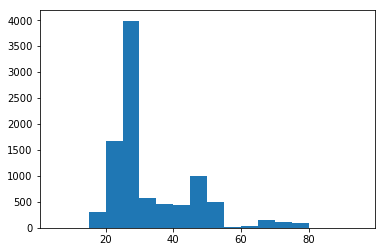

In [49]:
plt.hist(hail_samples_r * 25.4, bins=np.arange(5, 100, 5))

In [12]:
hail_reports.columns

Index(['om', 'yr', 'mo', 'dy', 'date', 'time', 'tz', 'st', 'stf', 'stn', 'mag',
       'inj', 'fat', 'loss', 'closs', 'slat', 'slon', 'elat', 'elon', 'len',
       'wid', 'ns', 'sn', 'sg', 'f1', 'f2', 'f3', 'f4'],
      dtype='object')

In [6]:
proj_params = dict(
            proj="lcc",
            a=6370000,
            b=6370000,
            lat_0=38.33643,
            lon_0=-101.,
            lat_1=32.0,
            lat_2=46.0,
            units="m")
us_proj = Proj(projparams=proj_params)

In [7]:
hail_report_x, hail_report_y = us_proj(hail_reports["slon"].values, hail_reports["slat"].values)

In [8]:
max_hail_x, max_hail_y = us_proj(hail_data[1]["center_lon"].values, hail_data[1]["center_lat"].values)

In [9]:
model_valid_dates = pd.DatetimeIndex(hail_data[1]["valid_dates"])
report_valid_dates = pd.DatetimeIndex(hail_reports["date"] + "T" + hail_reports["time"]) + pd.Timedelta(hours=6)
distances = np.arange(20000, 220000, 20000)
hail_ct = np.zeros((distances.size, 4), dtype=int)
for d, dist in enumerate(distances):
    for i in range(max_hail.size):
        if i % 10000 == 0:
            print(dist, i, hail_ct.sum(axis=0))
        time_diff = (np.abs(model_valid_dates[i] - report_valid_dates) < pd.Timedelta(hours=6))
        if np.count_nonzero(time_diff) == 0:
            if max_hail[i] >= 25:
                hail_ct[d, 1] += 1
            else:
                hail_ct[d, 3] += 1
            continue
        distance_diff = np.sqrt((max_hail_x[i] - hail_report_x[time_diff]) ** 2 + 
                                (max_hail_y[i] - hail_report_y[time_diff]) ** 2) < dist
        if np.count_nonzero(distance_diff) == 0:
            if max_hail[i] >= 25:
                hail_ct[d, 1] += 1
            else:
                hail_ct[d, 3] += 1
            continue
        max_hail_report_size = hail_reports.loc[time_diff, "mag"].loc[distance_diff].max() * 25.4
        if max_hail_report_size >= 25:
            if max_hail[i] > 25:
                hail_ct[d, 0] += 1
            else:
                hail_ct[d, 2] += 1
        

20000 0 [0 0 0 0]
20000 10000 [ 238 2849  368 6429]
20000 20000 [  715  5402   827 12758]
20000 30000 [  931  8272  1006 19381]
20000 40000 [ 1114 10746  1067 26625]
20000 50000 [ 1365 13708  1236 33200]
20000 60000 [ 1530 16428  1382 40093]
20000 70000 [ 1740 19481  1543 46584]
20000 80000 [ 1878 21991  1722 53669]
20000 90000 [ 2040 24609  1868 60656]
20000 100000 [ 2145 28126  1970 66839]
20000 110000 [ 2165 30159  2002 74739]
40000 0 [ 2168 30626  2009 78480]
40000 10000 [ 2722 33134  2952 84234]
40000 20000 [ 3777 35084  4031 89835]
40000 30000 [ 4229 37657  4495 96071]
40000 40000 [  4661  39874   4709 103130]
40000 50000 [  5265  42467   5196 109377]
40000 60000 [  5717  44850   5639 115886]
40000 70000 [  6264  47497   6118 121926]
40000 80000 [  6650  49720   6606 128627]
40000 90000 [  7090  52024   7006 135243]
40000 100000 [  7417  55232   7342 141058]
40000 110000 [  7482  57208   7484 148825]
60000 0 [  7498  57655   7517 152522]
60000 10000 [  8375  59826   9021 157612]


In [14]:
hail_ct_df = pd.DataFrame(hail_ct, index=(distances / 1000).astype(int), columns=["TP", "FP", "FN", "TN"])
hail_ct_df.to_csv("thompson_hail_ct_distance.csv", index_label="Distance")

In [29]:
hail_ct_df

,TP,FP,FN,TN
Distance,,,,
20,2168,30626,2009,78480
40,5330,27029,5508,74042
60,8498,23544,9533,69054
80,11493,20436,13613,64130
100,14158,17621,17545,59554
120,16467,15264,21451,55166
140,18439,13324,25104,51218
160,20042,11755,28448,47707
180,21396,10435,31527,44428


In [26]:
distances = np.arange(20000, 220000, 20000)

hail_ct_df = pd.read_csv("thompson_hail_ct_distance.csv", index_col="Distance")

In [37]:
ct_dists = np.array([ContingencyTable(*hail_ct_df.iloc[i]) for i in range(hail_ct_df.shape[0])])

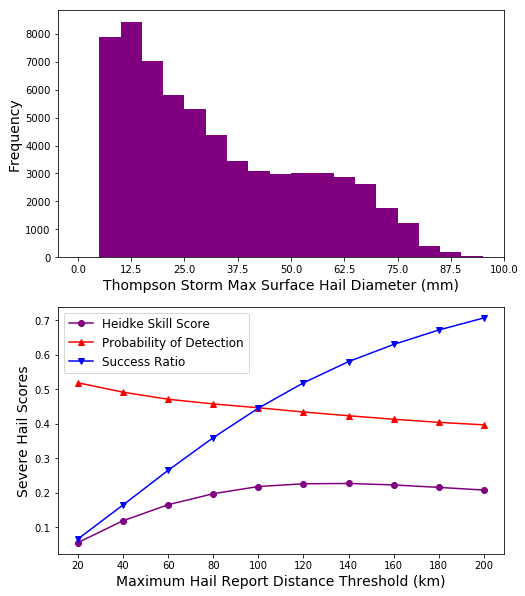

In [55]:
plt.figure(figsize=(8, 10))
plt.subplot(2, 1, 1)
plt.hist(hail_samples, bins=np.arange(0, 100, 5), color='purple', density=False)
#plt.hist(hail_samples_r * 25.4, bins=np.arange(5, 100, 5), color='blue', density=True)

#plt.hist(hail_reports.loc[hail_reports["mo"] == 5, "mag"] * 25.4, bins=np.arange(0, 100, 1), color='red', density=True)

plt.xticks(np.arange(0, 102, 12.5))
plt.xlabel("Thompson Storm Max Surface Hail Diameter (mm)", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.subplot(2, 1, 2)
plt.plot(distances / 1000, [ct_dists[i].hss() for i in range(ct_dists.size)], marker='o', color='purple', label="Heidke Skill Score")
plt.plot(distances / 1000, [ct_dists[i].pod() for i in range(ct_dists.size)], marker='^', color='r', label="Probability of Detection")
plt.plot(distances / 1000, [1-ct_dists[i].far() for i in range(ct_dists.size)], marker='v', color='blue', label="Success Ratio")
plt.legend(fontsize=12)
plt.xticks(np.arange(20, 220, 20))
plt.xlabel("Maximum Hail Report Distance Threshold (km)", fontsize=14)
plt.ylabel("Severe Hail Scores", fontsize=14)
plt.savefig("thompson_verif.pdf", bbox_inches="tight")

In [48]:
ct = ContingencyTable(*hail_ct.sum(axis=0))